# MLP GenCode 
We fixed a bug in notebook 103 which used only K=3.
Here repeat for K={1,2,3}.

In [1]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-12 14:59:10 UTC


In [2]:
PC_TRAINS=20000
NC_TRAINS=20000
PC_TESTS=5000
NC_TESTS=5000   # Wen et al 2019 used 8000 and 2000 of each class
PC_LENS=(200,4000)
NC_LENS=(200,4000)    # Wen et al 2019 used 250-3500 for lncRNA only
MAX_K = 3
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
EPOCHS=25
SPLITS=5
FOLDS=5   # make this 5 for serious testing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint


In [4]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [5]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME

In [6]:
# Full GenCode ver 38 human is 106143 pc + 48752 nc and loads in 7 sec.
# Expect fewer transcripts if special filtering is used.
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 70825
NC seqs loaded: 48752
2021-07-12 14:59:39 UTC


## Data Prep

In [7]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_shuffle(df):
    # The ignore_index option is new in Pandas 1.3. 
    # The default (False) replicates the old behavior: shuffle the index too.
    # The new option seems more logical th
    # After shuffling, df.iloc[0] has index == 0.
    # return df.sample(frac=1,ignore_index=True)
    return df.sample(frac=1)  # Use this till CoLab upgrades Pandas
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    dataframe_shuffle(
    dataframe_length_filter(pcdf,PC_LENS)))
nc_all = dataframe_extract_sequence(
    dataframe_shuffle(
    dataframe_length_filter(ncdf,NC_LENS)))

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-12 14:59:39 UTC
PC seqs pass filter: 55381
NC seqs pass filter: 46919


In [8]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None

PC train, NC train: 20000 20000
PC test, NC test: 5000 5000


In [9]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    labels1=np.ones(len1,dtype=np.int8)
    labels0=np.zeros(len0,dtype=np.int8)
    all_labels = np.concatenate((labels1,labels0))
    seqs1 = np.asarray(seqs1)
    seqs0 = np.asarray(seqs0)
    all_seqs = np.concatenate((seqs1,seqs0),axis=0)
    # return all_seqs,all_labels  # test unshuffled
    tandem=(all_seqs,all_labels)
    X,y = shuffle(tandem) # sklearn.utils.shuffle
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
#print(pc_train[0])
#print(Xseq[0],y[0])
show_time()

2021-07-12 14:59:40 UTC


In [10]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
show_time()
print("X shape",np.shape(Xfrq))
print(type(Xfrq),"of",type(Xfrq[0]),"of",type(Xfrq[0][0]))
print("y shape",np.shape(y))

2021-07-12 15:00:08 UTC
X shape (40000, 84)
<class 'numpy.ndarray'> of <class 'numpy.ndarray'> of <class 'numpy.float64'>
y shape (40000,)


## Neural network

In [11]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    #dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               10880     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
1000/1000 [==============================] - 16s 3ms/step - loss: 0.6724 - accuracy: 0.6134 - val_loss: 0.8052 - val_accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6663 - accuracy: 0.6199 - val_loss: 1.0617 - val_accuracy: 0.0000e+00
Epoch 3/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6602 - accuracy: 0.6270 - val_loss: 1.0208 - val_accuracy: 0.0000e+00
Epoch 4/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6556 - accuracy: 0.6271 - val_loss: 0.9657 - val_accuracy: 1.2500e-04
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6418 - accuracy: 0.6260 - val_loss: 0.7798 - val_accuracy: 0.0121
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 6/25
1000/1000 [==============================] - 2s 2ms/s

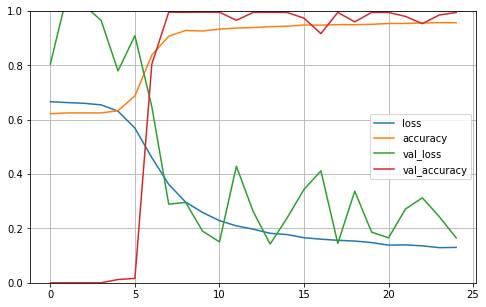

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
1000/1000 [==============================] - 3s 2ms/step - loss: 0.6823 - accuracy: 0.6105 - val_loss: 1.0203 - val_accuracy: 0.0000e+00
Epoch 2/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6652 - accuracy: 0.6229 - val_loss: 1.2481 - val_accuracy: 0.0000e+00
Epoch 3/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6639 - accuracy: 0.6226 - val_loss: 1.0213 - val_accuracy: 0.0000e+00
Epoch 4/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6587 - accuracy: 0.6239 - val_loss: 0.9101 - val_accuracy: 0.0000e+00
Epoch 5/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6497 - accuracy: 0.6249 - val_loss: 0.9092 - val_accuracy: 0.0000e+00
Epoch 6/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6148 - accuracy: 0.6504 - val_loss: 0.6702 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 7/25
1000/1000 

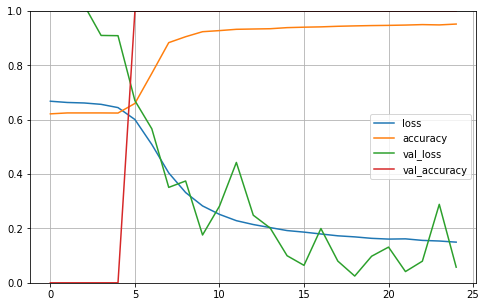

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6987 - accuracy: 0.4999 - val_loss: 0.7047 - val_accuracy: 0.5000
Epoch 2/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6952 - accuracy: 0.5048 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 3/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6898 - accuracy: 0.5364 - val_loss: 0.6898 - val_accuracy: 0.5000
Epoch 4/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6656 - accuracy: 0.6162 - val_loss: 0.6719 - val_accuracy: 0.7110
Epoch 5/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5539 - accuracy: 0.8182 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 6/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3306 - accuracy: 0.9619 - val_loss: 0.8244 - val_accuracy: 0.5000
Epoch 7/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.1766 - accuracy

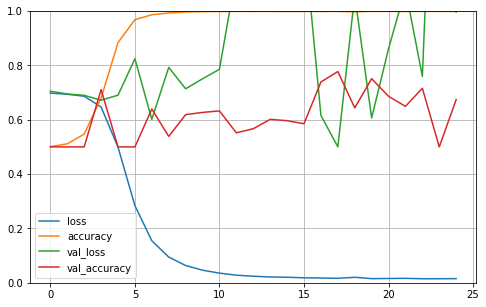

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6684 - accuracy: 0.6193 - val_loss: 0.9849 - val_accuracy: 0.0000e+00
Epoch 2/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6633 - accuracy: 0.6246 - val_loss: 0.9023 - val_accuracy: 0.0000e+00
Epoch 3/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6624 - accuracy: 0.6222 - val_loss: 0.7962 - val_accuracy: 0.0000e+00
Epoch 4/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6482 - accuracy: 0.6274 - val_loss: 1.0276 - val_accuracy: 0.0000e+00
Epoch 5/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6054 - accuracy: 0.6674 - val_loss: 0.6693 - val_accuracy: 0.6256
Epoch 6/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4798 - accuracy: 0.8490 - val_loss: 0.7487 - val_accuracy: 0.4518
Epoch 7/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0

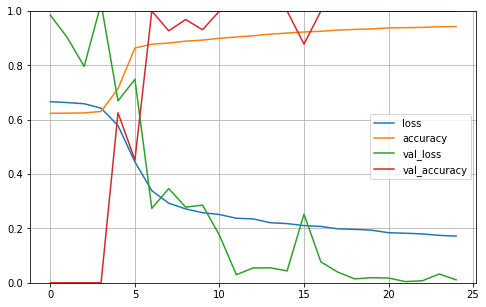

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6653 - accuracy: 0.6229 - val_loss: 1.2030 - val_accuracy: 0.0000e+00
Epoch 2/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6661 - accuracy: 0.6209 - val_loss: 1.1103 - val_accuracy: 0.0000e+00
Epoch 3/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6621 - accuracy: 0.6264 - val_loss: 1.0009 - val_accuracy: 0.0000e+00
Epoch 4/25
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6640 - accuracy: 0.6213 - val_loss: 1.0868 - val_accuracy: 0.0000e+00
Epoch 5/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6572 - accuracy: 0.6310 - val_loss: 0.8364 - val_accuracy: 0.0000e+00
Epoch 6/25
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6587 - accuracy: 0.6215 - val_loss: 0.6884 - val_accuracy: 0.7359
Epoch 7/25
1000/1000 [==============================] - 3s 3ms/step - los

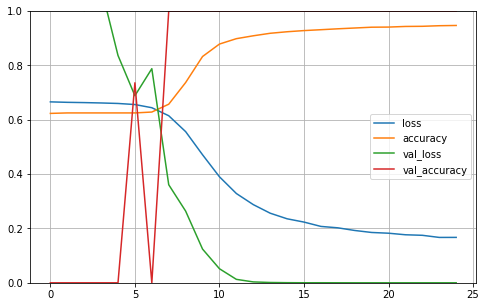

In [13]:
do_cross_validation(Xfrq,y)

In [14]:
# TO DO: run trained model on (pc_test,nc_test)
# and draw the AUC.
# Borrow code from other notebooks.